So you can make an ROC curve in pyplot but it looks like this.

![](https://i.imgur.com/3pEIjFt.png)

But fear not my friends, for Altair is here to fulfill all your aesthetic needs. In this amazing* blog I will introduce the ways of plotting an ROC curve in Altair.

In an ideal world, there will be an ROC curve in the [Altair example gallery](https://altair-viz.github.io/gallery/index.html), but the path to an ROC curve is harder than we wish for it to be.

(*Condition may apply)

ROC curve plots Sensitivity(True positive rate) and 1 - Specifity(False positive rate) on it's x and y axis. Before we get that, we need to first create a model. If you wish to skip all of that and get to the ROC curve, you can do that [here](#)

For this example, I am using titanic data from [Kaggle](https://www.kaggle.com/c/titanic)

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from sklearn import datasets
from sklearn_pandas import CategoricalImputer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.base import TransformerMixin

class SafeLabelBinarizer(TransformerMixin):

    def __init__(self):
        self.lb = LabelBinarizer()

    def fit(self, X):
        X = np.array(X)
        self.lb.fit(X)
        self.classes_ = self.lb.classes_

    def transform(self, X):
        K = np.append(self.classes_, ['__FAKE__'])
        X = label_binarize(X, K, pos_label=1, neg_label=0)
        X = np.delete(X, np.s_[-1], axis=1)
        return X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# in this house we mute our warnings
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.filterwarnings("ignore")

## Step 1: Load data
    
Load data, drop na, impute values(Preferebly after you train test split).

In [2]:
# load data
df = pd.read_csv('data/train.csv')

In [3]:
# drop na
df = df.dropna(subset = ['Embarked'])

In [4]:
# Dataframer to impute missing values, standard scale and label binarize
mapper = DataFrameMapper([
    ('Survived', None),
    ('Pclass', SafeLabelBinarizer()),
    ('Sex', LabelEncoder()),
    (['Age'], [SimpleImputer(strategy = 'mean'), StandardScaler()]),
    ('SibSp', None),
    ('Parch', None),
    (['Fare'], StandardScaler()),
    ('Embarked', SafeLabelBinarizer())
], df_out=True)
Z_df = mapper.fit_transform(df)

## Step 2: Train test split

In [5]:
# train test split
target = 'Survived'
X = Z_df.drop(target, axis = 1)
y = Z_df[target]
Z_train, Z_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Step 3: Feature Selection

In [6]:
# feature selection using ANOVA
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=20)
select.fit(Z_train, y_train)
Z_train_selected = select.transform(Z_train)

In [7]:
# find selected features and put it in a column
selection = select.get_support()
select_df = pd.DataFrame(zip(Z_train.columns.ravel(), selection), columns = ['feature', 'bool'])
select_df[select_df['bool']]

,feature,bool
3,Sex,True
7,Fare,True


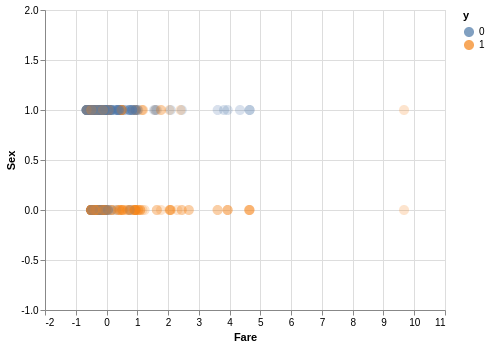

In [8]:
# scatter plot to see how our data is looking
import altair as alt
alt.renderers.enable('notebook')

# disable max rows
alt.data_transformers.disable_max_rows()


# put y_train in the same df as X_train
scatter_df = Z_train[['Sex', 'Fare']]
scatter_df['y'] = y_train


alt.Chart(scatter_df).mark_circle(size = 100, fillOpacity = 0.3).encode(
    alt.X('Fare', scale = alt.Scale(domain = [-2, 11])),
    alt.Y('Sex', scale = alt.Scale(domain = [-1,2])),
    color = 'y:N',
).interactive()

## Step 4: Model

What models can we try on this?
- knn
- logreg
- svm
- random forest
- bag

Let's try out all of them!

In the next block of code, I am going to set up a loop to fit these models and put their scores in a df for easier interpretation.

In [9]:
knn = KNeighborsClassifier(10)
logreg = LogisticRegression(solver = 'lbfgs')
svc = SVC(gamma = 'scale')
ada = AdaBoostClassifier()
bag = BaggingClassifier()
models = [knn, logreg, svc, ada, bag]
model_names = ['knn', 'logreg', 'svc', 'ada', 'bag']
model_score_dict = {}
model_no = 0
for model in models:
    model.fit(Z_train, y_train)
    model_tscore = model.score(Z_train, y_train)
    model_pscore = model.score(Z_test, y_test)
    model_score_dict.update({ model_names[model_no] : [model_tscore, model_pscore]})
    model_no += 1
model_score_df = pd.DataFrame(model_score_dict).T 
model_score_df.columns = ['train_score', 'test_score']
model_score_df

,train_score,test_score
knn,0.828829,0.789238
logreg,0.788288,0.802691
svc,0.831832,0.820628
ada,0.833333,0.811659
bag,0.966967,0.820628


Let's call a confusion matrix to identify our false positive and false negatives.

In [10]:
from sklearn.metrics import confusion_matrix
i = 0
fp = []
fn = []
for model in models:
    cm = confusion_matrix(y_train, model.predict(Z_train))
    fp.append(cm[0][1])
    fn.append(cm[1][0])
model_score_df['False positive'] = fp
model_score_df['False negative'] = fn
model_score_df

,train_score,test_score,False positive,False negative
knn,0.828829,0.789238,38,76
logreg,0.788288,0.802691,54,87
svc,0.831832,0.820628,39,73
ada,0.833333,0.811659,53,58
bag,0.966967,0.820628,7,15


At this point I will pick one model based of root mean squared errors since I don't want 5 different models. We want to minimize False positives, since it is predicting people to survive titanic falsely.

In [11]:
i = 0
rmse_train = []
rmse_test = []
for model in models:
    rmse_train.append(np.sqrt(mean_squared_error(y_train, model.predict(Z_train))))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, model.predict(Z_test)))) 
model_score_df['rmse train'] = rmse_train
model_score_df['rmse test'] = rmse_test
model_score_df

,train_score,test_score,False positive,False negative,rmse train,rmse test
knn,0.828829,0.789238,38,76,0.413728,0.459089
logreg,0.788288,0.802691,54,87,0.460121,0.444195
svc,0.831832,0.820628,39,73,0.410083,0.423524
ada,0.833333,0.811659,53,58,0.408248,0.433982
bag,0.966967,0.820628,7,15,0.181750,0.423524


Looking at the root mean squared error we can see that bag is massively overfitting. Among the others, since logreg has low number of false positives and not overfitting, I will be working with the logreg model going forward.

## Step 6: ROC curve

First, import roc_curve from sklearn.metrics

In [12]:
from sklearn.metrics import roc_curve

If we try using the roc_curve, we get a tuple of three arrays.

In [13]:
roc_curve(y_test, logreg.predict_proba(Z_test)[:,1])

(array([0.        , 0.        , 0.        , 0.0070922 , 0.0070922 ,
        0.0141844 , 0.0141844 , 0.0212766 , 0.0212766 , 0.02836879,
        0.02836879, 0.03546099, 0.03546099, 0.04255319, 0.04255319,
        0.05673759, 0.05673759, 0.06382979, 0.07092199, 0.07092199,
        0.07801418, 0.07801418, 0.08510638, 0.08510638, 0.09929078,
        0.09929078, 0.09929078, 0.12056738, 0.12056738, 0.13475177,
        0.13475177, 0.15602837, 0.15602837, 0.16312057, 0.16312057,
        0.19148936, 0.20567376, 0.21276596, 0.21276596, 0.23404255,
        0.23404255, 0.27659574, 0.27659574, 0.29078014, 0.29078014,
        0.38297872, 0.38297872, 0.39716312, 0.42553191, 0.42553191,
        0.45390071, 0.46808511, 0.46808511, 0.53191489, 0.53191489,
        0.54609929, 0.54609929, 0.58865248, 0.64539007, 0.66666667,
        0.66666667, 0.67375887, 0.67375887, 0.70212766, 0.70921986,
        0.72340426, 0.73758865, 0.75886525, 0.75886525, 0.78014184,
        0.79432624, 0.80141844, 0.80141844, 0.82

To better manage the output, we will tuple unpack it into fpr, tpr and thresholds and create a dataframe with the values

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(Z_test)[:,1])
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['thresholds'] = thresholds
roc_df.head()

,fpr,tpr,thresholds
0,0.000000,0.000000,1.997442
1,0.000000,0.012195,0.997442
2,0.000000,0.097561,0.948027
3,0.007092,0.097561,0.944747
4,0.007092,0.146341,0.912168


It is finally time for us to plot the ROC curve. The three plots can be created in any order, but it is important that they are stored in a variable and called at the end in order. I have mentioned the baseline last so that it is not masked by the area plot.

#### Plot ROC curve

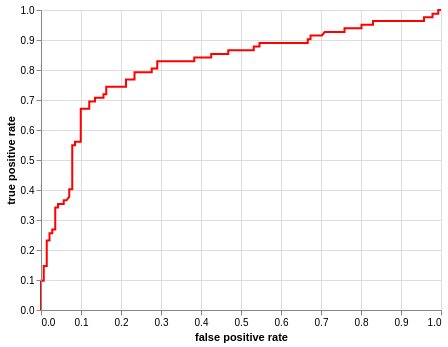

In [15]:
alt.Chart(roc_df).mark_line(color = 'red').encode(
                                                alt.X('fpr', title="false positive rate"),
                                                alt.Y('tpr', title="true positive rate"))

In [16]:
roc_line = alt.Chart(roc_df).mark_line(color = 'red').encode(
                                                                alt.X('fpr', title="false positive rate"),
                                                                alt.Y('tpr', title="true positive rate"))

#### Plot Area under the curve, AUC

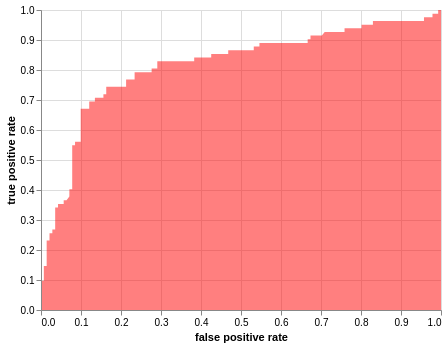

In [17]:
alt.Chart(roc_df).mark_area(fillOpacity = 0.5, fill = 'red').encode(
                                                                    alt.X('fpr', title="false positive rate"),
                                                                    alt.Y('tpr', title="true positive rate"))

In [18]:
roc = alt.Chart(roc_df).mark_area(fillOpacity = 0.5, fill = 'red').encode(
                                                                    alt.X('fpr', title="false positive rate"),
                                                                    alt.Y('tpr', title="true positive rate"))

#### Plot baseline(Perfect overlap between the two populations.)

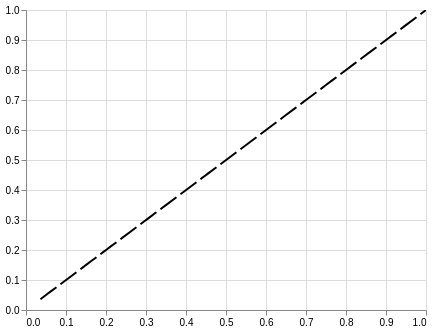

In [19]:
alt.Chart(roc_df).mark_line(strokeDash=[20,5], color = 'black').encode(
                                                                alt.X('thresholds', scale = alt.Scale(domain=[0, 1]), title=None),
                                                                alt.Y('thresholds', scale = alt.Scale(domain=[0, 1]), title=None)).interactive()

In [20]:
baseline = alt.Chart(roc_df).mark_line(strokeDash=[20,5], color = 'black').encode(
                                                                alt.X('thresholds', scale = alt.Scale(domain=[0, 1]), title=None),
                                                                alt.Y('thresholds', scale = alt.Scale(domain=[0, 1]), title=None))

Put them all together and you're done!

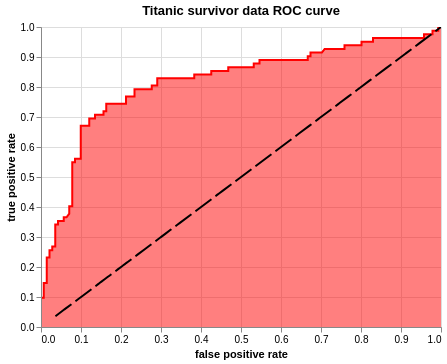

In [21]:
roc_line + roc + baseline.properties(
    title='Titanic survivor data ROC curve').interactive()